# Project description
The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.
One of the most common problems gyms and other services face is customer churn. How do you know if a customer is no longer with you? You can calculate churn based on people who get rid of their accounts or don't renew their contracts. However, sometimes it's not obvious that a client has left: they may walk out on tiptoes.
Churn indicators vary from field to field. If a user buys from an online store rarely but regularly, you can't say they're a runaway. But if for two weeks they haven't opened a channel that's updated daily, that's a reason to worry: your follower might have gotten bored and left you.
For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but's that's not a typical case. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.
In order to fight churn, Model Fitness has digitized a number of its customer profiles. Your task is to analyze them and come up with a customer retention strategy.
You should:
Learn to predict the probability of churn (for the upcoming month) for each customer
Draw up typical user portraits: select the most outstanding groups and describe their main features
Analyze the factors that impact churn most
Draw basic conclusions and develop recommendations on how to improve customer service:
Identify target groups
Suggest measures to cut churn
Describe any other patterns you see with respect to interaction with customers.

## exploratory data analysis (EDA)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
gym=pd.read_csv('/datasets/gym_churn_us.csv')
gym.columns = gym.columns.str.lower()
print(gym.shape)
print()
print(gym.info())
print()
print(gym.describe())
gym.head()


(4000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


We can see no NAN values, there are 4000 rows and 14 columns. Sevral columns has 1 and 0, for positive or negative, leaving it as is. we can see the standard deviation of churn which is low, which means that values tend to be close to the mean. We can also see almost equal amount of male and female.

### The mean feature values in two groups: for those who left (churn) and for those who stayed

In [3]:
mean_feature_values=gym.groupby('churn').mean().reset_index()
mean_feature_values

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


### Bar histograms and feature distributions for those who left (churn) and those who stayed. (Need to work on it!)

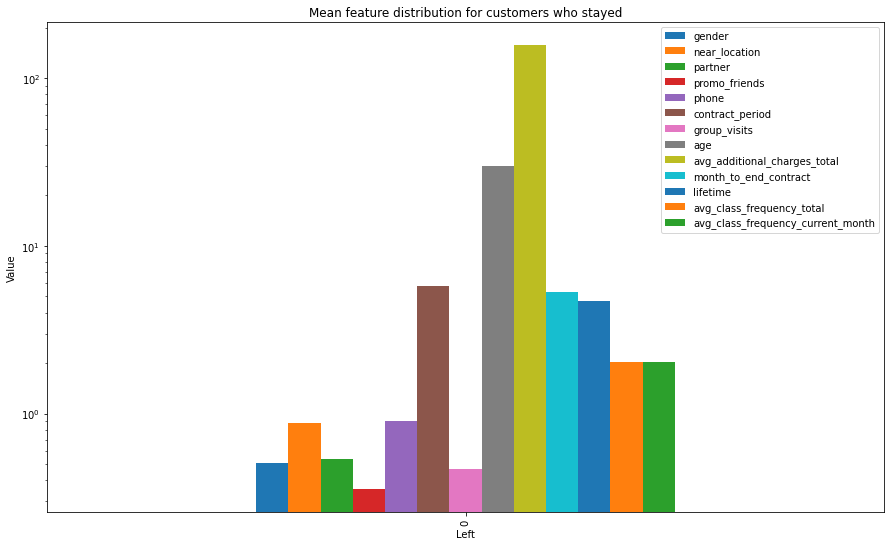

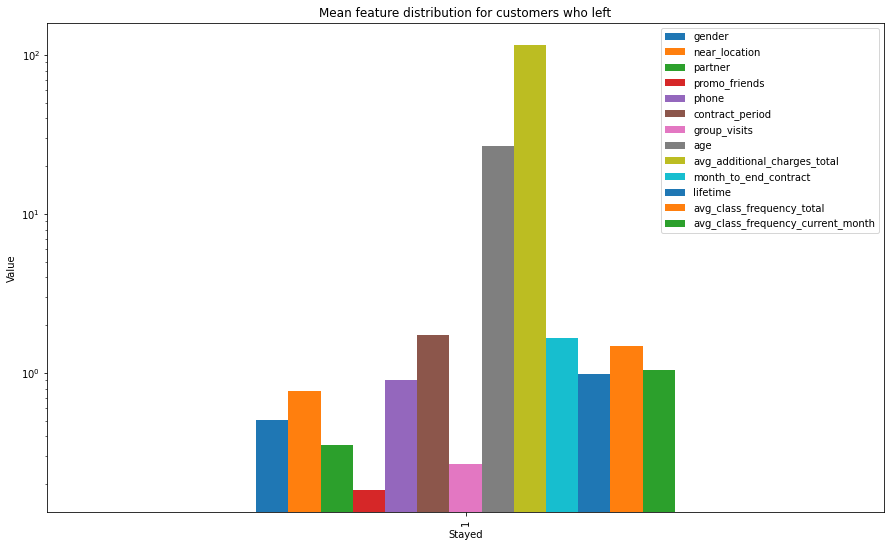

In [49]:

ax=mean_feature_values[mean_feature_values['churn'] == 0].drop('churn', axis=1).plot.bar(figsize=(15,9), title='Mean feature distribution for customers who stayed')
ax.set_ylabel("Value")
ax.set_xlabel("Left");
plt.yscale("log")
ax=mean_feature_values[mean_feature_values['churn'] == 1].drop('churn', axis=1).plot.bar(figsize=(15,9), title='Mean feature distribution for customers who left')
ax.set_xlabel("Stayed")
ax.set_ylabel("Value");
plt.yscale("log")

### Correlation matrix

<AxesSubplot:>

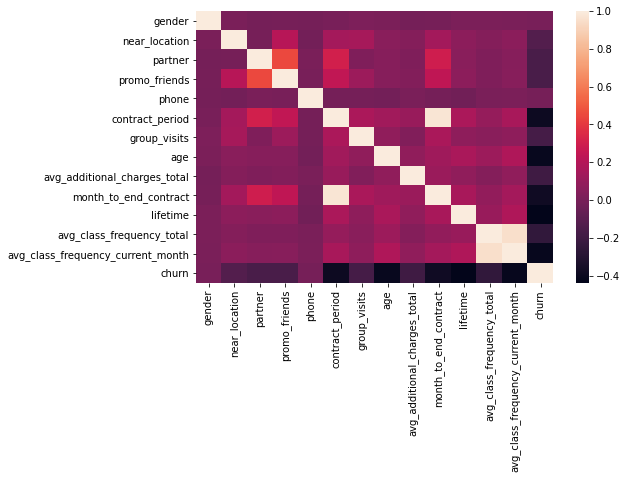

In [5]:
plt.figure(figsize=(8,5))
matrix=gym.corr()
sns.heatmap(matrix)

There is a correlation between partner and promo_friends, month_to_end_contract and contract period. Strongest correlation between contract_period and month_to_end_contract and between avg_class_frequency_current_month and avg_class_frequency_total.

## Build a model to predict user churn

In [6]:
# divide the data into features (the X matrix) and a target variable (y)
X = gym.drop('churn', axis=1)
y = gym['churn']

# define the function that will output our metrics
def print_all_metrics(y_true, y_pred, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
    
# divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

scaler = StandardScaler()
scaler.fit(X_train)

# transform train and test sets
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# define the algorithm for the logistic regression model
lr_model = LogisticRegression(random_state=0)
# train the model
lr_model.fit(X_train_st, y_train)
# use the trained model to make predictions
lr_predictions = lr_model.predict(X_test_st)
# print all metrics
print_all_metrics(y_test, lr_predictions, title='Metrics for logistic regression:')

print()
# define the algorithm for the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)
# train the model
rf_model.fit(X_train_st, y_train)
# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test_st)
# print all metrics
print_all_metrics(y_test, rf_predictions, title='Metrics for RandomForestClassifier:')

Metrics for logistic regression:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83

Metrics for RandomForestClassifier:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


After running the tests we can see that the logistic regression model is better as it has higher Precision and Recall scores.

## Create user clusters

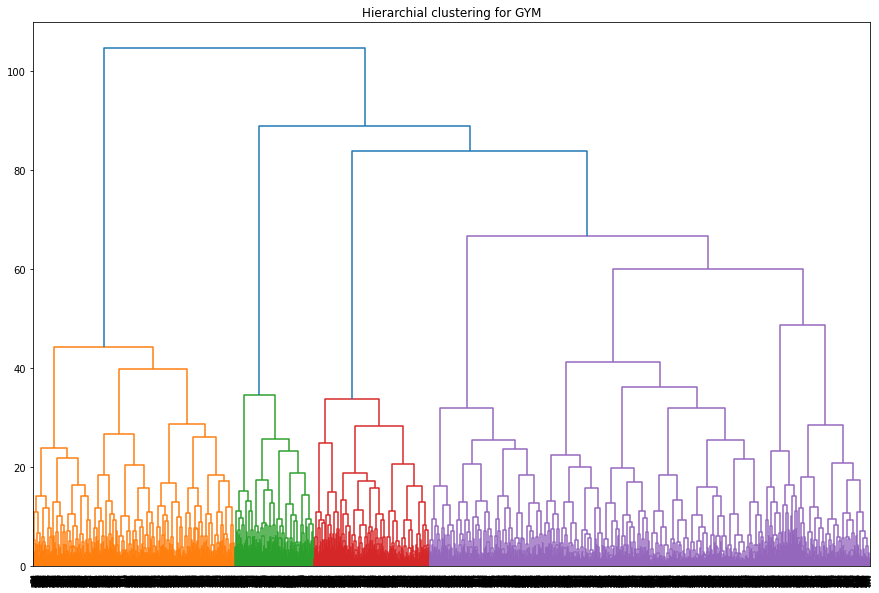

In [7]:
# obligatory standardization of data before passing it to the algorithm
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

### Train the clustering model with the K-means algorithm

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


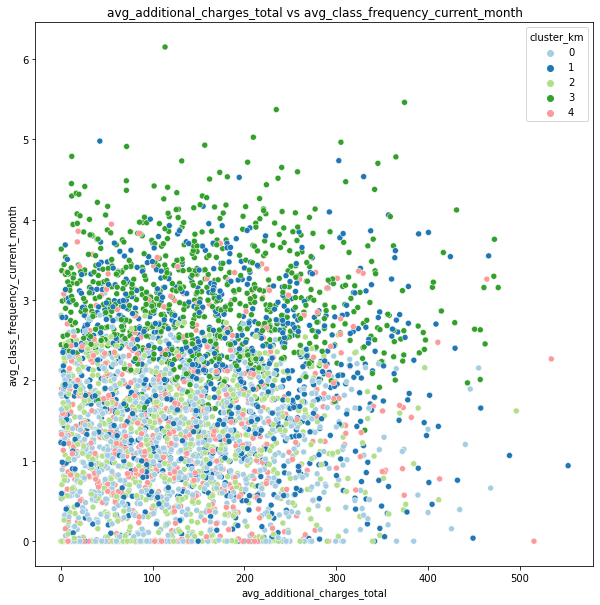

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.484484,1.000000,0.000000,0.085085,0.905906,1.798799,0.357357,28.291291,133.396352,1.731732,2.415415,1.400700,1.175811,0.515516
1,1,0.506821,0.945435,0.739769,0.513116,0.902413,11.779643,0.560336,29.922350,166.150184,10.784890,4.806925,1.996980,1.989702,0.020986
2,2,0.491892,1.000000,0.974324,0.583784,0.894595,2.956757,0.375676,28.668919,133.137132,2.748649,3.110811,1.388133,1.223096,0.350000
3,3,0.577428,0.972441,0.350394,0.244094,0.901575,3.017060,0.476378,30.438320,163.276198,2.766404,5.342520,2.992512,3.005306,0.028871
4,4,0.494505,0.000000,0.465201,0.076923,0.915751,2.225275,0.214286,28.478022,134.126172,2.089744,2.805861,1.659607,1.469327,0.448718


In [23]:
km = KMeans(n_clusters = 5) # setting the number of clusters as 5
labels = km.fit_predict(X_sc) # applying the algorithm to the data and forming a cluster

gym['cluster_km'] = labels

# define the function for rendering graphs of paired features for the clusters
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(df[x_name], df[y_name],
          hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
    
show_clusters_on_plot(gym, 'avg_additional_charges_total', 'avg_class_frequency_current_month', 'cluster_km')
clusters=gym.groupby('cluster_km').mean().reset_index()
clusters

We can see that clusters which have higher avg_class_frequency_current_month spend more on average on additional charges in the gym.

### Plot distributions of features for the clusters

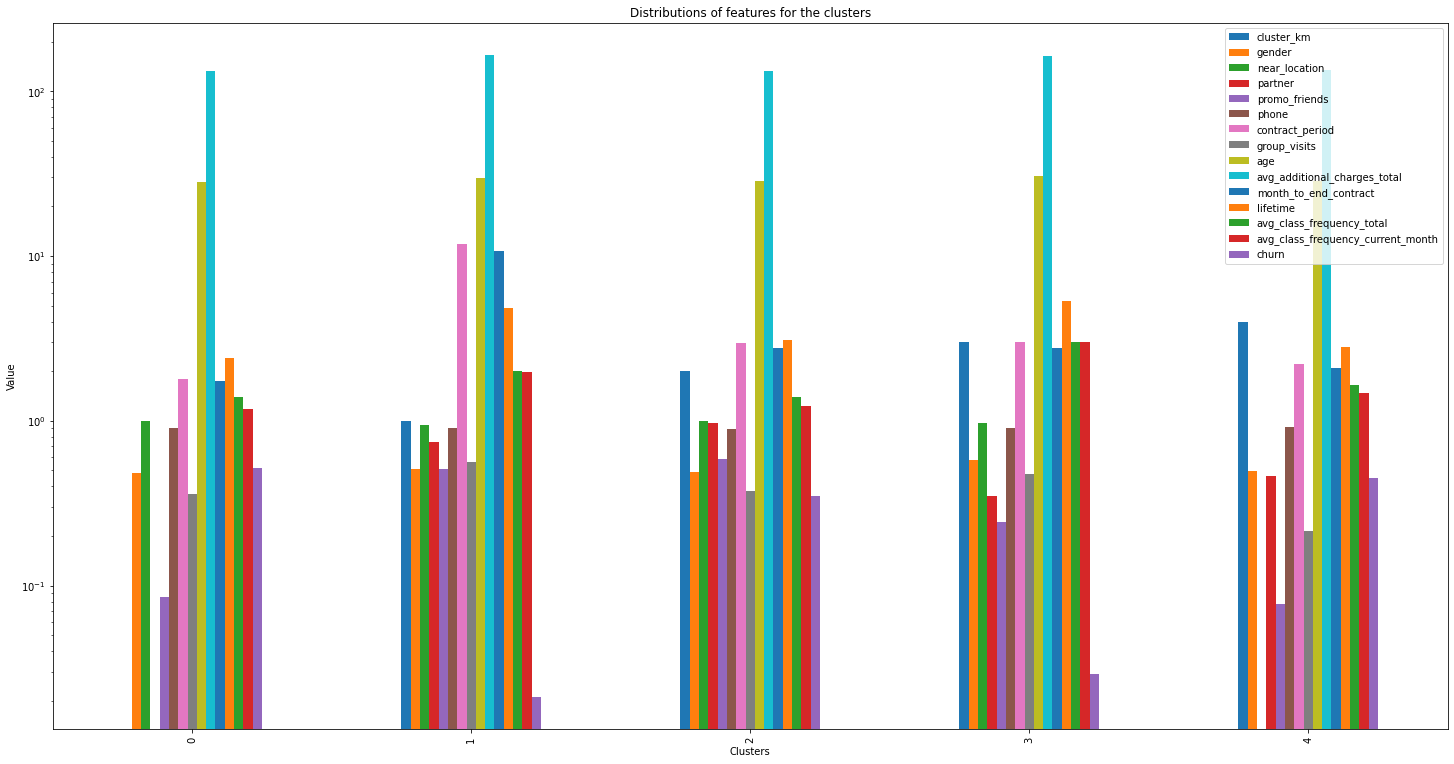

In [44]:
ax=clusters.plot.bar(figsize=(25,13), title='Distributions of features for the clusters')
plt.yscale("log")
ax.set_ylabel("Value")
ax.set_xlabel("Clusters");

### Calculate the churn rate for each cluster

In [9]:
gym.groupby('cluster_km').mean()['churn']

cluster_km
0    0.071596
1    0.520161
2    0.027586
3    0.441815
4    0.266839
Name: churn, dtype: float64

We can see that cluster 0 is the cluster that is prone to leaving while cluster 1 is the most loyal.

## conclusions and basic recommendations

From the clusters data we can see few issues that can be adderess in order to increase the customers retenion rates:

Group 0 which are prone to leave are distinct in several areas:

1. Distance from the gym: 
People from cluster 0 live the furthest away from the gym comparing to other clusters. Maybe it will be possible to open a new location? or find out if there are transportation routes to the gym from their locations?

2. Whether the user originally signed up through a "bring a friend" offer: 
group 0 has the least amount of members that join through the promo offer. Maybe the gym membership is to expensive for what the gym have to offer? Maybe it will be possible to offer another promotion to capture these customers as well.

3. contract period: 
group 0 don't sign in for a long membership at all. Maybe try to add a promotion to people that sign up for a long contract?

4. group visits:
group 0 do not usually visit in groups, which means that they might have no friend in the area, which is again correlated with the distance from the gym.

5. life time:
customers from group 0 leave the membership quite quickly after signin in. 

6. avg class frequency current month:
customers from group 0 do not participate as often in classes. Maybe try to run a questionnaire on which classes can be added to the gym, in order to retain those customers.

The second group which prone to leave is group 3 and it seems that they are also 2nd from the bottom when looking at group visits. It may be that people that train in group of friend are tend to stay for longer as a member.